# MNLogit Regression Analysis

#### This notebook performs a Multinomial Logistic Regression to estimate the impact of DEI policy rollbacks on Facebook comment sentiment (stance and purchase intention).

## 1. Imports and Configuration

In [52]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.mediation import Mediation
from tqdm import tqdm 
from tqdm import trange

# Configuration
DATA_FILE = "../../data/derived/comments_with_sentiment.csv"
DATA_DIR  = "../../data/derived"
TABLES_DIR = "../../results/tables/causal"
FIGURES_DIR = "../../results/figures/causal"

TREATED_COMPANIES = ['Google', 'Target']
EVENT_WINDOW_PRE = -15  # Days before announcement
EVENT_WINDOW_POST = 30  # Days after announcement
REFERENCE_DAY = -1      # Reference day for event study

STANCE_COL = 'gpt4o_pred_stance_label'
PI_COL = 'gpt4o_pred_pi_label'

# Define DEI Cutoff Dates (Announcement Dates)
DEI_CUTOFF_DATES = {
    'Costco': datetime(2025, 1, 23),
    'Delta': datetime(2025, 2, 4),
    'Google': datetime(2025, 2, 5),
    'Target': datetime(2025, 1, 24),
}

## 2. Helper Functions

In [53]:
def create_output_dirs():
    os.makedirs(TABLES_DIR, exist_ok=True)
    os.makedirs(FIGURES_DIR, exist_ok=True)

def plot_parallel_trends(df, var, label, filename):
    # pick only the comments you've already flagged as pre-event
    tmp = df[
        (df['before_DEI'] == 1)
        & (df['rel_day'].between(EVENT_WINDOW_PRE, -1))
    ].copy()

    # collapse to the post‐level
    post_avg = (
        tmp
        .groupby([
            'company_name',
            'post_date',
            'Treated_Company_Flag',
            'rel_day'
        ])[var]
        .mean()
        .reset_index()
    )

    # then average across posts by group & day
    daily = (
        post_avg
        .groupby(['Treated_Company_Flag', 'rel_day'])[var]
        .mean()
        .reset_index()
    )
    daily['Group'] = daily['Treated_Company_Flag'].map({0: 'Control', 1: 'Treated'})

    # plot
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=daily,
        x='rel_day',
        y=var,
        hue='Group',
        marker='o'
    )
    plt.title(f'Parallel Trends (Pre-event): {label}')
    plt.xlabel('Days Relative to Announcement')
    plt.ylabel(label)
    plt.xlim(EVENT_WINDOW_PRE, 0)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=300)
    plt.show()


def plot_event_study(df, var, label, filename):
    # pick only the comments you've already flagged as pre-event for the pre-period
    df_pre_period = df[
        (df['before_DEI'] == 1) &
        (df['rel_day'] < 0)  # df is df_did, already filtered to pre-event days within the window
    ].copy()
    # keep every post‐level day in the full window for the post-period
    df_post_period = df[
        df['rel_day'] >= 0  # df is df_did, already filtered to post-event days within the window
    ].copy()
    tmp = pd.concat([df_pre_period, df_post_period], ignore_index=True)

    # collapse and average just like above
    post_avg = (
        tmp
        .groupby([
            'company_name',
            'post_date',
            'Treated_Company_Flag',
            'rel_day'
        ])[var]
        .mean()
        .reset_index()
    )
    daily = (
        post_avg
        .groupby(['Treated_Company_Flag', 'rel_day'])[var]
        .mean()
        .reset_index()
    )
    daily['Group'] = daily['Treated_Company_Flag'].map({0: 'Control', 1: 'Treated'})

    # plot
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=daily,
        x='rel_day',
        y=var,
        hue='Group',
        marker='o'
    )
    plt.title(f'Event Study (Full): {label}')
    plt.xlabel('Days Relative to Announcement')
    plt.ylabel(label)
    plt.xlim(EVENT_WINDOW_PRE, EVENT_WINDOW_POST)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=300)
    plt.show()

def calculate_vif(model_results):
    """Calculate VIF for each outcome category in multinomial logistic regression."""
    vif_results = {}
    
    # Get the design matrix (same for all categories in multinomial logit)
    X = model_results.model.exog
    
    # Calculate VIF for each predictor
    vif = {}
    for j in range(X.shape[1]):
        if j == 0:  # Skip intercept
            continue
        # Regress this predictor on all other predictors
        y = X[:, j]
        X_others = np.delete(X, j, axis=1)
        # Add constant
        X_others = sm.add_constant(X_others)
        # Fit regression
        model = sm.OLS(y, X_others).fit()
        # Calculate VIF
        vif[model_results.model.exog_names[j]] = 1 / (1 - model.rsquared)
    
    # Store results for each category (same VIFs apply to all categories)
    for category in model_results.model.endog_names[1:]:
        vif_results[category] = vif
    
    return vif_results

def print_vif_scores(vif_results, model_name):
    """Print VIF scores in a formatted way."""
    print(f"\nVIF Scores for {model_name}:")
    # Just print for first category since VIFs are same for all
    category = list(vif_results.keys())[0]
    print(f"\nCategory: {category}")
    for var, vif in vif_results[category].items():
        print(f"{var}: {vif:.2f}")

# Fit baseline & FE models (clustered SEs by COMPANY)
def fit_mnl_standard(data, formula):
    """Fits MNLogit using standard .fit() with Newton solver and clustered SEs."""
    mod = smf.mnlogit(formula, data=data)
    return mod.fit(method='newton', maxiter=100, # Using standard fit with Newton
                   disp=False,
                   cov_type='cluster',
                   cov_kwds={'groups': data['company_name']})

# Fit baseline & FE models (clustered SEs by POST)
def fit_mnl_post(data, formula):
    """Fits MNLogit using standard .fit() with Newton solver and clustered SEs."""
    mod = smf.mnlogit(formula, data=data)
    return mod.fit(method='newton', maxiter=100, # Using standard fit with Newton
                   disp=False,
                   cov_type='cluster',
                   cov_kwds={'groups': data['post_id']})

# Fit baseline & FE models (clustered SEs by DATE)
def fit_mnl_date(data, formula):
    """Fits MNLogit using standard .fit() with Newton solver and clustered SEs."""
    mod = smf.mnlogit(formula, data=data)
    return mod.fit(method='newton', maxiter=100, # Using standard fit with Newton
                   disp=False,
                   cov_type='cluster',
                   cov_kwds={'groups': data['post_date']})

# Fit baseline & FE models (clustered SEs by COMPANY AND POST)
def fit_mnl_base_post(data, formula):
    """Fits MNLogit using standard .fit() with Newton solver and clustered SEs."""
    mod = smf.mnlogit(formula, data=data)

    # Factorize grouping variables for multi-way clustering
    codes_company, _ = pd.factorize(data['company_name'])
    codes_post, _ = pd.factorize(data['post_id'])
    
    # Combine factorized codes into a 2D numpy array
    # Each row corresponds to an observation, each column to a clustering dimension
    cluster_groups = np.column_stack((codes_company, codes_post))
    
    fitted_model = mod.fit(method='newton', maxiter=100, # Using standard fit with Newton
                   disp=False,
                   cov_type='cluster',
                   cov_kwds={'groups': cluster_groups})
    return fitted_model, cluster_groups

# Wild-cluster bootstrap
def wild_cluster_bootstrap_with_betas( # Renamed to match your call
    model_results,
    clusters,
    B: int = 2000,
    seed: int | None = 42,
    progress: bool = True,
) -> tuple[pd.Series, pd.DataFrame]: # Ensure return type hint matches
    # setup
    rng = np.random.default_rng(seed)
    param_mat = model_results.params.values          # shape (k_exog, J-1)
    beta_hat  = param_mat.flatten(order="F")         # (pk,) FORTRAN order
    bse_vec   = model_results.bse.values.flatten(order="F")
    t_obs     = model_results.tvalues.values.flatten(order="F")

    # Construct coef_index to match Fortran-style flattening (column by column)
    params_df = model_results.params
    idx_tuples = []
    # Iterate through outcomes (columns of params_df) first, then predictors (rows)
    for outcome_col_name in params_df.columns:
        for predictor_row_name in params_df.index:
            idx_tuples.append((predictor_row_name, outcome_col_name))
    
    # Use the names that .stack() would have produced for consistency
    original_stack_names = params_df.stack().index.names
    coef_index = pd.MultiIndex.from_tuples(idx_tuples, names=original_stack_names)

    # Hessian and its inverse (for one-step update)
    H_full = model_results.model.hessian(beta_hat)

    try:
        H_inv = np.linalg.inv(H_full)
    except np.linalg.LinAlgError:
        H_inv = np.linalg.pinv(H_full)

    score_i = model_results.model.score_obs(beta_hat)   # (N, pk) already col-wise
    df_score = pd.DataFrame(score_i)
    clusters_arr = np.asarray(clusters) # 'clusters' is the argument passed to the function

    if clusters_arr.ndim == 2 and clusters_arr.shape[1] > 1:
        # This case handles your two-way (or more-way) clustering.
        # It creates a single 1D array of unique string identifiers
        # for each combination of cluster variables.
        # e.g., if a row in clusters_arr is [0, 1], it becomes "0_1"
        processed_clusters_1d = ["_".join(map(str, row)) for row in clusters_arr]
        df_score["cluster"] = processed_clusters_1d
    elif clusters_arr.ndim == 1:
        # This handles the original one-way clustering case
        df_score["cluster"] = clusters_arr
    elif clusters_arr.ndim == 2 and clusters_arr.shape[1] == 1:
        # This handles the case where clusters might be (N, 1)
        df_score["cluster"] = clusters_arr.flatten()
    else:
        # If clusters_arr has an unexpected shape, raise an error
        raise ValueError(
            f"Clusters input has an unexpected shape: {clusters_arr.shape}. "
            "Expected 1D array or 2D array (N, k_cluster_vars)."
        )
    S_g = df_score.groupby("cluster").sum().values        # (G, pk)
    G   = S_g.shape[0]

    # storage for bootstrap t-statistics and coefficient distributions
    t_boot = np.empty((B, beta_hat.size))
    beta_star_dist = np.empty((B, beta_hat.size))
    
    # Use trange from tqdm.notebook if in a Jupyter notebook for better progress bar
    # from tqdm.notebook import trange 
    # iterator = trange(B, desc="Wild-cluster bootstrap", disable=not progress)
    # If not in a notebook, from tqdm import trange might be used,
    # or just range if tqdm is not critical
    iterator = range(B) # Fallback if trange is not set up, or use your existing iterator
    if progress:
        try:
            from tqdm import trange # Or tqdm.notebook.trange
            iterator = trange(B, desc="Wild-cluster bootstrap", disable=not progress)
        except ImportError:
            print("tqdm not found, progress bar will be disabled.")
            iterator = range(B)


    for b_idx in iterator: 
        w          = rng.choice([-1, 1], size=G)
        S_star     = (w[:, None] * S_g).sum(axis=0)
        beta_star  = beta_hat + H_inv @ S_star
        t_boot[b_idx] = (beta_star - beta_hat) / bse_vec
        beta_star_dist[b_idx] = beta_star

    p_boot = (np.abs(t_boot) >= np.abs(t_obs)).mean(axis=0)
    
    p_values_series = pd.Series(p_boot, index=coef_index, name="p_WCB")
    beta_dist_df = pd.DataFrame(beta_star_dist, columns=coef_index)
    
    # CRITICAL: Ensure this return statement provides exactly two items
    return p_values_series, beta_dist_df

## 3. Setup Environment

In [54]:
# Set seaborn style globally
sns.set_style('whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
create_output_dirs()

## 4. Load and Prepare Data

In [55]:
# Load data
df = pd.read_csv(DATA_FILE, parse_dates=['comment_date', 'post_date'], date_format='%Y-%m-%d %H:%M:%S')
df['comment_date'] = pd.to_datetime(df['comment_date'], errors='coerce') # Ensure datetime type
df['post_date'] = pd.to_datetime(df['post_date'], errors='coerce') # Ensure datetime type for post_date

# Ensure IDs
if 'id' not in df.columns:
    df = df.reset_index().rename(columns={'index':'id'})

# Create a post_id to cluster by post
df['post_id'] = df['company_name'] + '_' + df['post_date'].dt.strftime('%Y-%m-%d')

# Flags and outcomes
df['Treated_Company_Flag'] = df['company_name'].isin(TREATED_COMPANIES).astype(int)

# Assign announcement_date directly from DEI_CUTOFF_DATES
df['announcement_date'] = df['company_name'].map(DEI_CUTOFF_DATES)
df['announcement_date'] = pd.to_datetime(df['announcement_date'], errors='coerce') # Ensure datetime type

df['rel_day'] = (df['post_date'] - df['announcement_date']).dt.days # Changed to use post_date


df['is_boycott'] = (df[PI_COL] == -1).astype(int)
df['is_buy'] = (df[PI_COL] == 1).astype(int)

# Print company info
company_info = df.groupby('company_name').agg(
    announcement_date = ('announcement_date', 'first'),
    Treated_Company_Flag = ('Treated_Company_Flag', 'first')
).reset_index()
print("\nCompany Announcement Dates and Treatment Status:")
print(company_info)


Company Announcement Dates and Treatment Status:
  company_name announcement_date  Treated_Company_Flag
0       Costco        2025-01-23                     0
1        Delta        2025-02-04                     0
2       Google        2025-02-05                     1
3       Target        2025-01-24                     1


/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_2005/2191467371.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['comment_date'] = pd.to_datetime(df['comment_date'], errors='coerce') # Ensure datetime type
/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_2005/2191467371.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['post_date'] = pd.to_datetime(df['post_date'], errors='coerce') # Ensure datetime type for post_date


## 5. Multinomial Logistic Regression

In [56]:
# 1. Create new features
df['comment_length'] = df.get('comment_text', '').str.len().fillna(0)
df['log_reactions'] = np.log1p(df.get('reaction_count', 0))

# 2. Select and clean data
cols = [PI_COL, STANCE_COL, 'has_DEI', 'rel_day', 'company_name', 'post_date', 'post_id',
        'log_reactions', 'comment_length', 'Treated_Company_Flag'] # Added Treated_Company_Flag and post_id
df_mnl = df[cols].dropna().copy()

# 3. Center continuous covariates & rename for clarity in output
df_mnl['log_react_c'] = df_mnl['log_reactions'] - df_mnl['log_reactions'].mean()
df_mnl['comment_len_c'] = df_mnl['comment_length'] - df_mnl['comment_length'].mean()
df_mnl.drop(columns=['log_reactions', 'comment_length'], inplace=True) # Drop original now centered

# 4. Pre/post indicator
df_mnl['pre_event'] = (df['before_DEI'] == 1).astype(int)

# 5. Outcome mapping: Neutral=0, Boycott=1, Buy=2
df_mnl['pi_cat'] = df_mnl[PI_COL].map({0:0, -1:1, 1:2})

# 6. Create descriptive string versions of categorical predictors for formula
df_mnl['stance'] = df_mnl[STANCE_COL].map({
    -1: 'Anti_DEI',
    0:  'Neutral_DEI', # Reference for stance
    1:  'Pro_DEI'
})
df_mnl['policy'] = df_mnl['has_DEI'].map({
    0: 'Rolled_Back_DEI',
    1: 'Maintained_DEI' # Reference for policy status
})

# 7. Create explicit interaction term for Pro_DEI * Rolled_Back_DEI
# Note: This interaction is equivalent to Pro_DEI * Treated_Company_Flag in this setup
# because only treated companies rolled back DEI
df_mnl['pro_dei_rollback'] = (
    (df_mnl['stance'] == 'Pro_DEI') & (df_mnl['policy'] == 'Rolled_Back_DEI')
).astype(int)

# 8. Select final columns and drop intermediates
df_mnl_final = df_mnl.drop(columns=[PI_COL, STANCE_COL, 'has_DEI'], errors='ignore').copy()

# Save df_mnl_final as a .csv for potential external use (e.g., Stata wild cluster bootstrap)
# Ensure the directory exists
os.makedirs(DATA_DIR, exist_ok=True)
output_path = os.path.join(DATA_DIR, 'df_mnl_final.csv')
df_mnl_final.to_csv(output_path, index=False)
print(f"Saved MNL analysis data to {output_path}")

# Baseline model: pre/post, stance, policy, interaction, controls
base_fml = ("pi_cat ~ pre_event "
            "+ C(stance, Treatment('Neutral_DEI')) "
            "+ C(policy, Treatment('Maintained_DEI')) " # Policy main effect
            "+ C(stance, Treatment('Neutral_DEI')) * C(policy, Treatment('Maintained_DEI'))"
            "+ log_react_c + comment_len_c")

# Baseline model: pre/post, stance, policy, interaction, controls
base_no_stance_fml = ("pi_cat ~ pre_event "
            "+ C(policy, Treatment('Maintained_DEI')) " # Policy main effect
            "+ log_react_c + comment_len_c")

# Fixed Effects model: pre/post, stance, interaction, controls, company FE
# Policy main effect drops out due to collinearity with company FE
fe_fml   = ("pi_cat ~ pre_event "
            "+ C(stance, Treatment('Neutral_DEI'))"
            "+ C(company_name, Treatment(reference='Costco'))" # Company Fixed Effects
            "+ log_react_c + comment_len_c ")

print(df_mnl_final.head())

Saved MNL analysis data to ../../data/derived/df_mnl_final.csv
   rel_day company_name           post_date            post_id  \
0      -14       Costco 2025-01-09 09:00:00  Costco_2025-01-09   
1      -14       Costco 2025-01-09 09:00:00  Costco_2025-01-09   
2      -14       Costco 2025-01-09 09:00:00  Costco_2025-01-09   
3      -14       Costco 2025-01-09 09:00:00  Costco_2025-01-09   
4      -14       Costco 2025-01-09 09:00:00  Costco_2025-01-09   

   Treated_Company_Flag  log_react_c  comment_len_c  pre_event  pi_cat  \
0                     0     2.905484     -52.194676          1       0   
1                     0    -0.783396      70.805324          1       0   
2                     0    -0.090248     -86.194676          1       0   
3                     0     1.296046     -64.194676          1       0   
4                     0    -0.783396     -75.194676          1       0   

        stance          policy  pro_dei_rollback  
0  Neutral_DEI  Maintained_DEI              

## 5.1. Baseline Model

In [57]:
# Fit baseline model using the standard helper function
print("\nFitting Baseline MNLogit Model (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_base = fit_mnl_standard(df_mnl_final, base_fml)

print(res_base.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_base)
print_vif_scores(vif_results, "Baseline Model")


Fitting Baseline MNLogit Model (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33042
Method:                           MLE   Df Model:                           16
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.2293
Time:                        21:12:43   Log-Likelihood:                -13538.
converged:                       True   LL-Null:                       -17564.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------

In [58]:
# Call the modified bootstrap function
# (ensure res_base is your MNLogit results object and df_mnl_final['company_name'] is the cluster variable)
bootstrap_p_values_series, bootstrap_beta_distributions_df = wild_cluster_bootstrap_with_betas(
    model_results = res_base,
    clusters      = df_mnl_final["company_name"],
    B             = 2000, # Or your desired number of bootstrap repetitions
    seed          = 42
)

# Analysis Setup
# Predictor names (from the rows of the params table)
predictor_names = res_base.params.index.tolist()
# Number of predictors
k_exog = len(predictor_names)

# Outcome mapping based on your p_table code: .rename(columns={0: "boycott", 1: "buy"})
outcome_map = {"boycott": 0, "buy": 1} # outcome_name: model_idx
outcome_names = ["boycott", "buy"]

all_bootstrap_results = {} # Initialize dictionary to store results

# Process and Report Results for each Outcome
for outcome_name in outcome_names:
    outcome_model_idx = outcome_map[outcome_name]

    print(f"\n--- Results for '{outcome_name.capitalize()}' Outcome (vs. Neutral) ---")

    # 1. Extract Bootstrapped Log-Odds for the current outcome
    # These columns are initially ordered by model_results.params.index
    log_odds_boot_for_outcome_df = bootstrap_beta_distributions_df.xs(outcome_model_idx, level=1, axis=1)
    
    # 2. Calculate Percentile CIs and Original ORs for each predictor
    bootstrap_or_cis_list = []
    
    # Iterate using predictor_names from res_base.params.index, which defines the output table rows
    for pred_name in predictor_names:
        # Get the original point estimate
        original_log_odds = res_base.params.loc[pred_name].iloc[outcome_model_idx]
        original_or = np.exp(original_log_odds)

        # Check if this predictor exists in the bootstrapped data columns for this outcome
        if pred_name in log_odds_boot_for_outcome_df.columns:
            # Access the specific series of bootstrapped log-odds for this predictor
            current_log_odds_boot_series = log_odds_boot_for_outcome_df[pred_name]
            current_odds_ratios_boot_series = np.exp(current_log_odds_boot_series)
            
            lower_ci, upper_ci = np.percentile(current_odds_ratios_boot_series, [2.5, 97.5])
            
            # --- Debugging print:
            # print(f"Pred: {pred_name[:30]:<30} | Orig LogOdds: {original_log_odds:.3f} | Boot Mean LogOdds: {current_log_odds_boot_series.mean():.3f} | Orig OR: {original_or:.3f} | CI: [{lower_ci:.3f}, {upper_ci:.3f}]")

            bootstrap_or_cis_list.append({
                "Predictor": pred_name,
                "Point_Estimate_OR": original_or,
                "Bootstrap_CI_Lower": lower_ci,
                "Bootstrap_CI_Upper": upper_ci
            })
        else:
            # This should ideally not happen if res_base.params.index and model_results.params.index match
            print(f"WARNING: Predictor '{pred_name}' from res_base.params not found in bootstrap distribution columns for outcome '{outcome_name}'.")
            bootstrap_or_cis_list.append({
                "Predictor": pred_name,
                "Point_Estimate_OR": original_or, # Still report original OR
                "Bootstrap_CI_Lower": np.nan,
                "Bootstrap_CI_Upper": np.nan
            })
            
    df_bootstrap_cis = pd.DataFrame(bootstrap_or_cis_list).set_index("Predictor")
    # Ensure the final DataFrame rows are in the order of predictor_names (should be by construction here)
    df_bootstrap_cis = df_bootstrap_cis.reindex(predictor_names)
    # Reorder columns for presentation
    df_bootstrap_cis = df_bootstrap_cis[["Point_Estimate_OR", "Bootstrap_CI_Lower", "Bootstrap_CI_Upper"]]

    # Store both df_bootstrap_cis and log_odds_boot_for_outcome_df
    all_bootstrap_results[outcome_name] = {
        'cis_df': df_bootstrap_cis.copy(),
        'log_odds_df': log_odds_boot_for_outcome_df.copy()
    }

    # 4. Report p-values (assuming this part is okay)
    p_values_outcome = bootstrap_p_values_series.xs(outcome_model_idx, level=1)
    # Ensure p_values_outcome Series is indexed by predictor_names in the correct order before printing
    p_values_outcome = p_values_outcome.reindex(predictor_names) 
    p_values_outcome.name = "p_WCB"
    print(f"\nBootstrap p-values for '{outcome_name.capitalize()}':")
    print(p_values_outcome.to_string(float_format='{:.4f}'.format))

    all_bootstrap_results[outcome_name] = {
        'cis_df'       : df_bootstrap_cis.copy(),
        'log_odds_df'  : log_odds_boot_for_outcome_df.copy(),
        'pvals'        : p_values_outcome.copy()      
    }

Wild-cluster bootstrap: 100%|██████████| 2000/2000 [00:00<00:00, 90089.65it/s]


--- Results for 'Boycott' Outcome (vs. Neutral) ---

Bootstrap p-values for 'Boycott':
Intercept                                                                                                   0.0000
C(stance, Treatment('Neutral_DEI'))[T.Anti_DEI]                                                             0.0000
C(stance, Treatment('Neutral_DEI'))[T.Pro_DEI]                                                              0.4885
C(policy, Treatment('Maintained_DEI'))[T.Rolled_Back_DEI]                                                   0.0000
C(stance, Treatment('Neutral_DEI'))[T.Anti_DEI]:C(policy, Treatment('Maintained_DEI'))[T.Rolled_Back_DEI]   0.0000
C(stance, Treatment('Neutral_DEI'))[T.Pro_DEI]:C(policy, Treatment('Maintained_DEI'))[T.Rolled_Back_DEI]    0.0000
pre_event                                                                                                   0.0000
log_react_c                                                                                                

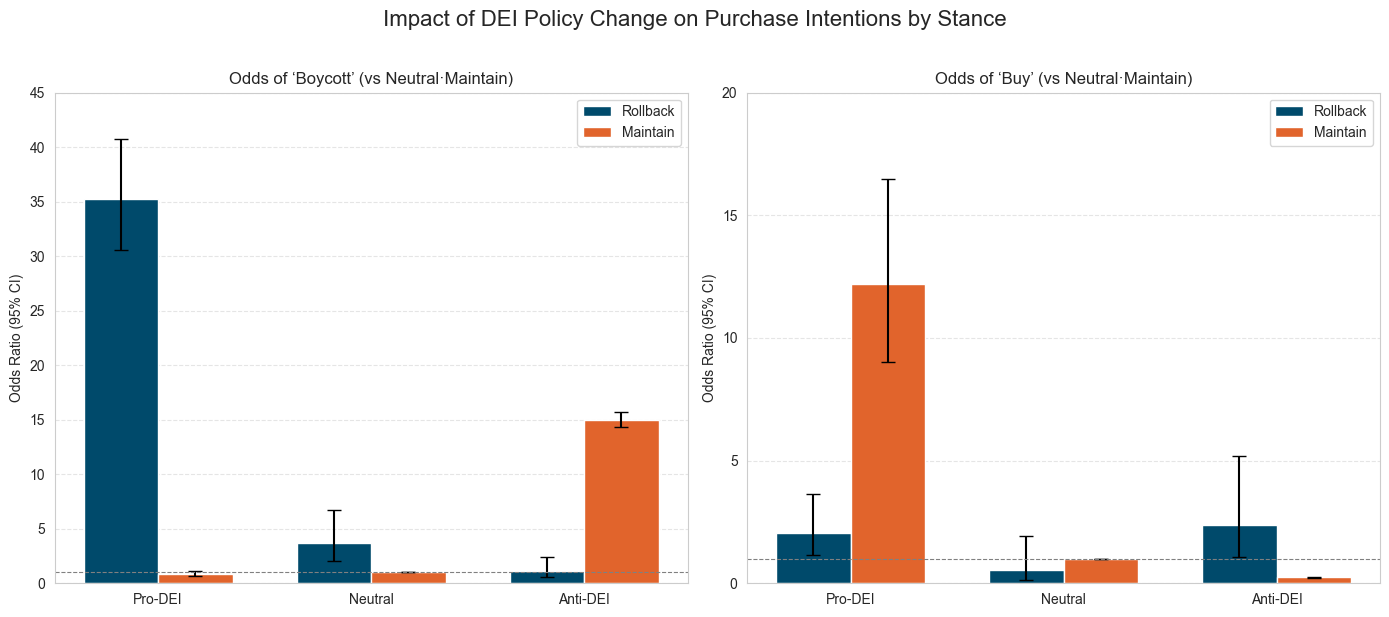


=== Odds-ratio table for 'Boycott' ===
  Stance   Policy    OR          95% CI pboot
 Pro-DEI Maintain  0.88   (0.69 – 1.11) 0.488
 Pro-DEI Rollback 35.28 (30.58 – 40.71) 0.000
 Neutral Maintain  1.00   (1.00 – 1.00)     —
 Neutral Rollback  3.69   (2.02 – 6.75) 0.000
Anti-DEI Maintain 14.99 (14.34 – 15.67) 0.000
Anti-DEI Rollback  1.14   (0.53 – 2.44) 0.000

=== Odds-ratio table for 'Buy' ===
  Stance   Policy    OR         95% CI pboot
 Pro-DEI Maintain 12.18 (9.00 – 16.48) 0.000
 Pro-DEI Rollback  2.05  (1.16 – 3.63) 0.000
 Neutral Maintain  1.00  (1.00 – 1.00)     —
 Neutral Rollback  0.53  (0.14 – 1.93) 0.497
Anti-DEI Maintain  0.24  (0.21 – 0.27) 0.000
Anti-DEI Rollback  2.36  (1.07 – 5.21) 0.000

=== Publication table for Boycott ===
                                                                                                Predictor   Coef    OR CI_Lower CI_Upper pboot
                                                                                                Intercept

In [59]:
# 1) Configuration — new left→right order
stances = ["Pro-DEI", "Neutral", "Anti-DEI"]
param = {
    "Anti-DEI": {
        "main": "C(stance, Treatment('Neutral_DEI'))[T.Anti_DEI]",
        "int":  "C(stance, Treatment('Neutral_DEI'))[T.Anti_DEI]:C(policy, Treatment('Maintained_DEI'))[T.Rolled_Back_DEI]"
    },
    "Pro-DEI": {
        "main": "C(stance, Treatment('Neutral_DEI'))[T.Pro_DEI]",
        "int":  "C(stance, Treatment('Neutral_DEI'))[T.Pro_DEI]:C(policy, Treatment('Maintained_DEI'))[T.Rolled_Back_DEI]"
    }
}
policy_main = "C(policy, Treatment('Maintained_DEI'))[T.Rolled_Back_DEI]"

plot_data = {}

# 2) Build OR + CI lists in original Anti→Neutral→Pro order, then reorder
for outcome in outcome_names:
    boot_lo = all_bootstrap_results[outcome]['log_odds_df']
    df_cis  = all_bootstrap_results[outcome]['cis_df']

    or_m, lo_m, hi_m = [], [], []
    or_r, lo_r, hi_r = [], [], []

    # -- Anti-DEI --
    dist_m_anti  = np.exp(boot_lo[param["Anti-DEI"]["main"]])
    or_main_anti = df_cis.loc[param["Anti-DEI"]["main"], "Point_Estimate_OR"]
    or_m.append(or_main_anti)
    lo_m.append(np.percentile(dist_m_anti,  2.5))
    hi_m.append(np.percentile(dist_m_anti, 97.5))

    dist_r_anti  = np.exp(
        boot_lo[param["Anti-DEI"]["main"]] +
        boot_lo[policy_main] +
        boot_lo[param["Anti-DEI"]["int"]]
    )
    or_policy    = df_cis.loc[policy_main, "Point_Estimate_OR"]
    or_int_anti  = df_cis.loc[param["Anti-DEI"]["int"], "Point_Estimate_OR"]
    or_r.append(or_main_anti * or_policy * or_int_anti)
    lo_r.append(np.percentile(dist_r_anti,  2.5))
    hi_r.append(np.percentile(dist_r_anti, 97.5))

    # -- Neutral --
    or_m.append(1.0); lo_m.append(1.0); hi_m.append(1.0)
    dist_r_neut = np.exp(boot_lo[policy_main])
    or_neut_r   = df_cis.loc[policy_main, "Point_Estimate_OR"]
    or_r.append(or_neut_r)
    lo_r.append(np.percentile(dist_r_neut,  2.5))
    hi_r.append(np.percentile(dist_r_neut, 97.5))

    # -- Pro-DEI --
    dist_m_pro  = np.exp(boot_lo[param["Pro-DEI"]["main"]])
    or_main_pro = df_cis.loc[param["Pro-DEI"]["main"], "Point_Estimate_OR"]
    or_m.append(or_main_pro)
    lo_m.append(np.percentile(dist_m_pro,  2.5))
    hi_m.append(np.percentile(dist_m_pro, 97.5))

    dist_r_pro  = np.exp(
        boot_lo[param["Pro-DEI"]["main"]] +
        boot_lo[policy_main] +
        boot_lo[param["Pro-DEI"]["int"]]
    )
    or_int_pro  = df_cis.loc[param["Pro-DEI"]["int"], "Point_Estimate_OR"]
    or_r.append(or_main_pro * or_policy * or_int_pro)
    lo_r.append(np.percentile(dist_r_pro,  2.5))
    hi_r.append(np.percentile(dist_r_pro, 97.5))

    # ── NOW REORDER ──
    order = [2, 1, 0]  # Pro, Neutral, Anti
    m_or  = np.array(or_m)[order]
    m_err = np.vstack([
        np.array(or_m) - np.array(lo_m),
        np.array(hi_m) - np.array(or_m)
    ])[:, order]
    r_or  = np.array(or_r)[order]
    r_err = np.vstack([
        np.array(or_r) - np.array(lo_r),
        np.array(hi_r) - np.array(or_r)
    ])[:, order]

    plot_data[outcome] = {
        "m_or":  m_or,
        "m_err": m_err,
        "r_or":  r_or,
        "r_err": r_err
    }

# 3) Plot with the new order and your custom y-limits
x = np.arange(len(stances))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)

for ax, outcome in zip(axes, outcome_names):
    d = plot_data[outcome]

    ax.bar(x - width/2, d["r_or"], width,
           yerr=d["r_err"], capsize=5, label="Rollback", color="#004A6B")
    ax.bar(x + width/2, d["m_or"], width,
           yerr=d["m_err"], capsize=5, label="Maintain", color="#E1642C")

    ax.set_xticks(x)
    ax.set_xticklabels(stances)
    ax.axhline(1, color="gray", linestyle="--", linewidth=0.8)

    # keep only horizontal grid lines, turn off vertical ones:
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.grid(axis="x", visible=False)

    if outcome == "boycott":
        ax.set_ylim(0, 45)
        ax.set_yticks(np.arange(0, 46, 5))
    else:
        ax.set_ylim(0, 20)
        ax.set_yticks(np.arange(0, 21, 5))

    ax.set_title(f"Odds of ‘{outcome.capitalize()}’ (vs Neutral·Maintain)")
    ax.set_ylabel("Odds Ratio (95% CI)")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Impact of DEI Policy Change on Purchase Intentions by Stance", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Convenience: pull p-values once so we don’t hit the dict repeatedly
pvals = {out: all_bootstrap_results[out]['pvals']          # or ['boot_pvals']
         for out in outcome_names}

tables = {}           # keep a handle in case you want to export later
for outcome in outcome_names:
    rows = []
    d     = plot_data[outcome]

    # ----------------  Helper to fetch pboot  ---------------------
    def get_p(term):
        """Return two-tailed wild-cluster p-value for a model term;
           returns NaN if the term is 1.0 (reference)"""
        return pvals[outcome].get(term, float('nan'))

    # ----------------  Loop over stances  -------------------------
    for idx, stance in enumerate(stances):          # Pro, Neutral, Anti

        # Maintain (baseline or main effect only)
        if stance == "Neutral":
            or_m  = 1.00
            lo_m, hi_m = 1.00, 1.00
            p_m   = float('nan')
        else:
            term  = param[stance]["main"]
            or_m  = d["m_or"][idx]
            lo_m  = or_m - d["m_err"][0, idx]
            hi_m  = or_m + d["m_err"][1, idx]
            p_m   = get_p(term)

        rows.append({
            "Stance" : stance,
            "Policy" : "Maintain",
            "OR"     : f"{or_m:,.2f}",
            "95% CI" : f"({lo_m:,.2f} – {hi_m:,.2f})",
            "pboot"  : f"{p_m:.3f}" if pd.notna(p_m) else "—"
        })

        # Rollback (multiply through for combined effect)
        if stance == "Neutral":
            or_r   = d["r_or"][idx]
            lo_r   = or_r - d["r_err"][0, idx]
            hi_r   = or_r + d["r_err"][1, idx]
            p_r    = get_p(policy_main)
        else:
            term_int = param[stance]["int"]
            or_r   = d["r_or"][idx]
            lo_r   = or_r - d["r_err"][0, idx]
            hi_r   = or_r + d["r_err"][1, idx]
            # For transparency we quote the interaction p-value, which drives
            # the difference relative to Maintain
            p_r    = get_p(term_int)

        rows.append({
            "Stance" : stance,
            "Policy" : "Rollback",
            "OR"     : f"{or_r:,.2f}",
            "95% CI" : f"({lo_r:,.2f} – {hi_r:,.2f})",
            "pboot"  : f"{p_r:.3f}" if pd.notna(p_r) else "—"
        })

    # ----------------  Pretty-print  -------------------------------
    tbl = pd.DataFrame(rows)
    tables[outcome] = tbl                                     # store
    print(f"\n=== Odds-ratio table for '{outcome.capitalize()}' ===")
    print(tbl.to_string(index=False))

    tables_pub = {}

for outcome_name in outcome_names:                       # 'boycott', 'buy'
    idx_out = outcome_map[outcome_name]                  # 0 or 1
    cis_df  = all_bootstrap_results[outcome_name]['cis_df']
    pvals   = all_bootstrap_results[outcome_name]['pvals']

    rows = []
    for pred in predictor_names:                         # preserves model order
        beta      = res_base.params.loc[pred].iloc[idx_out]
        or_point  = cis_df.loc[pred, "Point_Estimate_OR"]
        ci_lower  = cis_df.loc[pred, "Bootstrap_CI_Lower"]
        ci_upper  = cis_df.loc[pred, "Bootstrap_CI_Upper"]
        p_boot    = pvals.loc[pred]

        rows.append({
            "Predictor": pred,
            "Coef"     : f"{beta:.3f}",
            "OR"       : f"{or_point:.2f}",
            "CI_Lower" : f"{ci_lower:.2f}",
            "CI_Upper" : f"{ci_upper:.2f}",
            "pboot"    : f"{p_boot:.3f}"
        })

    tbl_pub = pd.DataFrame(rows)
    tables_pub[outcome_name] = tbl_pub

    print(f"\n=== Publication table for {outcome_name.capitalize()} ===")
    print(tbl_pub.to_string(index=False))


## 5.1 (Continued) Baseline Model w/o Stance

In [60]:
# Fit baseline model using the standard helper function
print("\nFitting Baseline MNLogit Model w/o Stance (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_base = fit_mnl_standard(df_mnl_final, base_no_stance_fml)

print(res_base.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_base)
print_vif_scores(vif_results, "Baseline Model")


Fitting Baseline MNLogit Model w/o Stance (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33050
Method:                           MLE   Df Model:                            8
Date:                Mon, 26 May 2025   Pseudo R-squ.:                 0.08814
Time:                        21:12:44   Log-Likelihood:                -16016.
converged:                       True   LL-Null:                       -17564.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                     

## 5.2. Fixed Effects Model

In [61]:
# Fit fixed effects model using the standard helper function
print("\nFitting Fixed Effects MNLogit Model (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_fe = fit_mnl_standard(df_mnl_final, fe_fml)

print(res_fe.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_fe)
print_vif_scores(vif_results, "Fixed Effects Model")


Fitting Fixed Effects MNLogit Model (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33042
Method:                           MLE   Df Model:                           16
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.2206
Time:                        21:12:44   Log-Likelihood:                -13689.
converged:                       True   LL-Null:                       -17564.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                             

## 5.3 Baseline Model (Clustered by post_id)

In [62]:
# Number of unique posts (>50 for clustering)
df_mnl_final["post_id"].nunique() 

95

In [63]:
# Fit baseline model using the standard helper function and clustered by POST
print("\nFitting Baseline MNLogit Model (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_base = fit_mnl_post(df_mnl_final, base_fml)

print(res_base.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_base)
print_vif_scores(vif_results, "Baseline Model (Clustered by Post_id)")


Fitting Baseline MNLogit Model (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33042
Method:                           MLE   Df Model:                           16
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.2293
Time:                        21:12:44   Log-Likelihood:                -13538.
converged:                       True   LL-Null:                       -17564.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------

In [64]:
# Call the modified bootstrap function
# (ensure res_base is your MNLogit results object and df_mnl_final['post_id'] is the cluster variable)
bootstrap_p_values_series, bootstrap_beta_distributions_df = wild_cluster_bootstrap_with_betas(
    model_results = res_base,
    clusters      = df_mnl_final["post_id"],
    B             = 2000, # Or your desired number of bootstrap repetitions
    seed          = 42
)

# Analysis Setup
# Predictor names (from the rows of the params table)
predictor_names = res_base.params.index.tolist()
# Number of predictors
k_exog = len(predictor_names)

# Outcome mapping based on your p_table code: .rename(columns={0: "boycott", 1: "buy"})
outcome_map = {"boycott": 0, "buy": 1} # outcome_name: model_idx
outcome_names = ["boycott", "buy"]

# Process and Report Results for each Outcome
for outcome_name in outcome_names:
    outcome_model_idx = outcome_map[outcome_name]

    print(f"\n--- Results for '{outcome_name.capitalize()}' Outcome (vs. Neutral) ---")

    # 1. Extract Bootstrapped Log-Odds for the current outcome
    # These columns are initially ordered by model_results.params.index
    log_odds_boot_for_outcome_df = bootstrap_beta_distributions_df.xs(outcome_model_idx, level=1, axis=1)
    
    # 2. Calculate Percentile CIs and Original ORs for each predictor
    bootstrap_or_cis_list = []
    
    # Iterate using predictor_names from res_base.params.index, which defines the output table rows
    for pred_name in predictor_names:
        # Get the original point estimate
        original_log_odds = res_base.params.loc[pred_name].iloc[outcome_model_idx]
        original_or = np.exp(original_log_odds)

        # Check if this predictor exists in the bootstrapped data columns for this outcome
        if pred_name in log_odds_boot_for_outcome_df.columns:
            # Access the specific series of bootstrapped log-odds for this predictor
            current_log_odds_boot_series = log_odds_boot_for_outcome_df[pred_name]
            current_odds_ratios_boot_series = np.exp(current_log_odds_boot_series)
            
            lower_ci, upper_ci = np.percentile(current_odds_ratios_boot_series, [2.5, 97.5])
            
            # --- Debugging print:
            # print(f"Pred: {pred_name[:30]:<30} | Orig LogOdds: {original_log_odds:.3f} | Boot Mean LogOdds: {current_log_odds_boot_series.mean():.3f} | Orig OR: {original_or:.3f} | CI: [{lower_ci:.3f}, {upper_ci:.3f}]")

            bootstrap_or_cis_list.append({
                "Predictor": pred_name,
                "Point_Estimate_OR": original_or,
                "Bootstrap_CI_Lower": lower_ci,
                "Bootstrap_CI_Upper": upper_ci
            })
        else:
            # This should ideally not happen if res_base.params.index and model_results.params.index match
            print(f"WARNING: Predictor '{pred_name}' from res_base.params not found in bootstrap distribution columns for outcome '{outcome_name}'.")
            bootstrap_or_cis_list.append({
                "Predictor": pred_name,
                "Point_Estimate_OR": original_or, # Still report original OR
                "Bootstrap_CI_Lower": np.nan,
                "Bootstrap_CI_Upper": np.nan
            })
            
    df_bootstrap_cis = pd.DataFrame(bootstrap_or_cis_list).set_index("Predictor")
    # Ensure the final DataFrame rows are in the order of predictor_names (should be by construction here)
    df_bootstrap_cis = df_bootstrap_cis.reindex(predictor_names)
    # Reorder columns for presentation
    df_bootstrap_cis = df_bootstrap_cis[["Point_Estimate_OR", "Bootstrap_CI_Lower", "Bootstrap_CI_Upper"]]

    print(f"\nBootstrap Odds Ratio 95% CIs for '{outcome_name.capitalize()}':")
    print(df_bootstrap_cis.to_string(formatters={
        'Point_Estimate_OR': '{:.3f}'.format,
        'Bootstrap_CI_Lower': '{:.3f}'.format,
        'Bootstrap_CI_Upper': '{:.3f}'.format
    }))

    # 4. Report p-values (assuming this part is okay)
    p_values_outcome = bootstrap_p_values_series.xs(outcome_model_idx, level=1)
    # Ensure p_values_outcome Series is indexed by predictor_names in the correct order before printing
    p_values_outcome = p_values_outcome.reindex(predictor_names) 
    p_values_outcome.name = "p_WCB"
    print(f"\nBootstrap p-values for '{outcome_name.capitalize()}':")
    print(p_values_outcome.to_string(float_format='{:.4f}'.format))

Wild-cluster bootstrap: 100%|██████████| 2000/2000 [00:00<00:00, 94567.48it/s]


--- Results for 'Boycott' Outcome (vs. Neutral) ---

Bootstrap Odds Ratio 95% CIs for 'Boycott':
                                                                                                          Point_Estimate_OR Bootstrap_CI_Lower Bootstrap_CI_Upper
Predictor                                                                                                                                                        
Intercept                                                                                                             0.035              0.027              0.046
C(stance, Treatment('Neutral_DEI'))[T.Anti_DEI]                                                                      14.988             12.231             18.370
C(stance, Treatment('Neutral_DEI'))[T.Pro_DEI]                                                                        0.877              0.568              1.342
C(policy, Treatment('Maintained_DEI'))[T.Rolled_Back_DEI]                                   

## 5.4 Baseline Model (Clustered by post_date)

In [65]:
# Number of unique post dates (>50 for clustering)
df_mnl_final["post_date"].nunique() 

118

In [66]:
# Fit baseline model using the standard helper function and clustered by DATE
print("\nFitting Baseline MNLogit Model (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_base = fit_mnl_date(df_mnl_final, base_fml)

print(res_base.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_base)
print_vif_scores(vif_results, "Baseline Model (Clustered by Post_date)")


Fitting Baseline MNLogit Model (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33042
Method:                           MLE   Df Model:                           16
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.2293
Time:                        21:12:45   Log-Likelihood:                -13538.
converged:                       True   LL-Null:                       -17564.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------

In [67]:
# Call the modified bootstrap function
# (ensure res_base is your MNLogit results object and df_mnl_final['post_date'] is the cluster variable)
bootstrap_p_values_series, bootstrap_beta_distributions_df = wild_cluster_bootstrap_with_betas(
    model_results = res_base,
    clusters      = df_mnl_final["post_date"],
    B             = 2000, # Or your desired number of bootstrap repetitions
    seed          = 42
)

# Analysis Setup
# Predictor names (from the rows of the params table)
predictor_names = res_base.params.index.tolist()
# Number of predictors
k_exog = len(predictor_names)

# Outcome mapping based on your p_table code: .rename(columns={0: "boycott", 1: "buy"})
outcome_map = {"boycott": 0, "buy": 1} # outcome_name: model_idx
outcome_names = ["boycott", "buy"]

# Process and Report Results for each Outcome
for outcome_name in outcome_names:
    outcome_model_idx = outcome_map[outcome_name]

    print(f"\n--- Results for '{outcome_name.capitalize()}' Outcome (vs. Neutral) ---")

    # 1. Extract Bootstrapped Log-Odds for the current outcome
    # These columns are initially ordered by model_results.params.index
    log_odds_boot_for_outcome_df = bootstrap_beta_distributions_df.xs(outcome_model_idx, level=1, axis=1)
    
    # 2. Calculate Percentile CIs and Original ORs for each predictor
    bootstrap_or_cis_list = []
    
    # Iterate using predictor_names from res_base.params.index, which defines the output table rows
    for pred_name in predictor_names:
        # Get the original point estimate
        original_log_odds = res_base.params.loc[pred_name].iloc[outcome_model_idx]
        original_or = np.exp(original_log_odds)

        # Check if this predictor exists in the bootstrapped data columns for this outcome
        if pred_name in log_odds_boot_for_outcome_df.columns:
            # Access the specific series of bootstrapped log-odds for this predictor
            current_log_odds_boot_series = log_odds_boot_for_outcome_df[pred_name]
            current_odds_ratios_boot_series = np.exp(current_log_odds_boot_series)
            
            lower_ci, upper_ci = np.percentile(current_odds_ratios_boot_series, [2.5, 97.5])
            
            # --- Debugging print:
            # print(f"Pred: {pred_name[:30]:<30} | Orig LogOdds: {original_log_odds:.3f} | Boot Mean LogOdds: {current_log_odds_boot_series.mean():.3f} | Orig OR: {original_or:.3f} | CI: [{lower_ci:.3f}, {upper_ci:.3f}]")

            bootstrap_or_cis_list.append({
                "Predictor": pred_name,
                "Point_Estimate_OR": original_or,
                "Bootstrap_CI_Lower": lower_ci,
                "Bootstrap_CI_Upper": upper_ci
            })
        else:
            # This should ideally not happen if res_base.params.index and model_results.params.index match
            print(f"WARNING: Predictor '{pred_name}' from res_base.params not found in bootstrap distribution columns for outcome '{outcome_name}'.")
            bootstrap_or_cis_list.append({
                "Predictor": pred_name,
                "Point_Estimate_OR": original_or, # Still report original OR
                "Bootstrap_CI_Lower": np.nan,
                "Bootstrap_CI_Upper": np.nan
            })
            
    df_bootstrap_cis = pd.DataFrame(bootstrap_or_cis_list).set_index("Predictor")
    # Ensure the final DataFrame rows are in the order of predictor_names (should be by construction here)
    df_bootstrap_cis = df_bootstrap_cis.reindex(predictor_names)
    # Reorder columns for presentation
    df_bootstrap_cis = df_bootstrap_cis[["Point_Estimate_OR", "Bootstrap_CI_Lower", "Bootstrap_CI_Upper"]]

    print(f"\nBootstrap Odds Ratio 95% CIs for '{outcome_name.capitalize()}':")
    print(df_bootstrap_cis.to_string(formatters={
        'Point_Estimate_OR': '{:.3f}'.format,
        'Bootstrap_CI_Lower': '{:.3f}'.format,
        'Bootstrap_CI_Upper': '{:.3f}'.format
    }))

    # 4. Report p-values (assuming this part is okay)
    p_values_outcome = bootstrap_p_values_series.xs(outcome_model_idx, level=1)
    # Ensure p_values_outcome Series is indexed by predictor_names in the correct order before printing
    p_values_outcome = p_values_outcome.reindex(predictor_names) 
    p_values_outcome.name = "p_WCB"
    print(f"\nBootstrap p-values for '{outcome_name.capitalize()}':")
    print(p_values_outcome.to_string(float_format='{:.4f}'.format))

Wild-cluster bootstrap: 100%|██████████| 2000/2000 [00:00<00:00, 90146.77it/s]


--- Results for 'Boycott' Outcome (vs. Neutral) ---

Bootstrap Odds Ratio 95% CIs for 'Boycott':
                                                                                                          Point_Estimate_OR Bootstrap_CI_Lower Bootstrap_CI_Upper
Predictor                                                                                                                                                        
Intercept                                                                                                             0.035              0.026              0.046
C(stance, Treatment('Neutral_DEI'))[T.Anti_DEI]                                                                      14.988             12.069             18.479
C(stance, Treatment('Neutral_DEI'))[T.Pro_DEI]                                                                        0.877              0.566              1.350
C(policy, Treatment('Maintained_DEI'))[T.Rolled_Back_DEI]                                   

## 5.5 Baseline Model (Clustered by comapany_name AND post_id)

In [68]:
# Fit baseline model using the standard helper function and clustered by COMPANY AND POST
print("\nFitting Baseline MNLogit Model (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_base, cluster_groups_base = fit_mnl_base_post(df_mnl_final, base_fml)

print(res_base.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_base)
print_vif_scores(vif_results, "Baseline Model (Clustered by company_name and post_id)")


Fitting Baseline MNLogit Model (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33042
Method:                           MLE   Df Model:                           16
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.2293
Time:                        21:12:45   Log-Likelihood:                -13538.
converged:                       True   LL-Null:                       -17564.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------

## 5.7 Bootstrap for Alternative Clustering

In [69]:
# 1. Call model
fitted_model_post, model_cluster_groups = fit_mnl_base_post(df_mnl_final, base_fml)

# 2. Call the bootstrap function with the FITTED model object and the cluster_groups from the model fitting
bootstrap_p_values_series, bootstrap_beta_distributions_df = wild_cluster_bootstrap_with_betas(
    model_results = fitted_model_post,     # Use the fitted model object
    clusters      = model_cluster_groups,  # Use cluster_groups returned by fit_mnl_base_post
    B             = 2000,
    seed          = 42
)

# Analysis Setup
# Predictor names (from the rows of the params table)
predictor_names = res_base.params.index.tolist()
# Number of predictors
k_exog = len(predictor_names)

# Outcome mapping based on your p_table code: .rename(columns={0: "boycott", 1: "buy"})
outcome_map = {"boycott": 0, "buy": 1} # outcome_name: model_idx
outcome_names = ["boycott", "buy"]

# Process and Report Results for each Outcome
# Process and Report Results for each Outcome
for outcome_name in outcome_names:
    outcome_model_idx = outcome_map[outcome_name]

    print(f"\n--- Results for '{outcome_name.capitalize()}' Outcome (vs. Neutral) ---")

    # 1. Extract Bootstrapped Log-Odds for the current outcome
    # These columns are initially ordered by model_results.params.index
    log_odds_boot_for_outcome_df = bootstrap_beta_distributions_df.xs(outcome_model_idx, level=1, axis=1)
    
    # 2. Calculate Percentile CIs and Original ORs for each predictor
    bootstrap_or_cis_list = []
    
    # Iterate using predictor_names from res_base.params.index, which defines the output table rows
    for pred_name in predictor_names:
        # Get the original point estimate
        original_log_odds = res_base.params.loc[pred_name].iloc[outcome_model_idx]
        original_or = np.exp(original_log_odds)

        # Check if this predictor exists in the bootstrapped data columns for this outcome
        if pred_name in log_odds_boot_for_outcome_df.columns:
            # Access the specific series of bootstrapped log-odds for this predictor
            current_log_odds_boot_series = log_odds_boot_for_outcome_df[pred_name]
            current_odds_ratios_boot_series = np.exp(current_log_odds_boot_series)
            
            lower_ci, upper_ci = np.percentile(current_odds_ratios_boot_series, [2.5, 97.5])
            
            # --- Debugging print:
            # print(f"Pred: {pred_name[:30]:<30} | Orig LogOdds: {original_log_odds:.3f} | Boot Mean LogOdds: {current_log_odds_boot_series.mean():.3f} | Orig OR: {original_or:.3f} | CI: [{lower_ci:.3f}, {upper_ci:.3f}]")

            bootstrap_or_cis_list.append({
                "Predictor": pred_name,
                "Point_Estimate_OR": original_or,
                "Bootstrap_CI_Lower": lower_ci,
                "Bootstrap_CI_Upper": upper_ci
            })
        else:
            # This should ideally not happen if res_base.params.index and model_results.params.index match
            print(f"WARNING: Predictor '{pred_name}' from res_base.params not found in bootstrap distribution columns for outcome '{outcome_name}'.")
            bootstrap_or_cis_list.append({
                "Predictor": pred_name,
                "Point_Estimate_OR": original_or, # Still report original OR
                "Bootstrap_CI_Lower": np.nan,
                "Bootstrap_CI_Upper": np.nan
            })
            
    df_bootstrap_cis = pd.DataFrame(bootstrap_or_cis_list).set_index("Predictor")
    # Ensure the final DataFrame rows are in the order of predictor_names (should be by construction here)
    df_bootstrap_cis = df_bootstrap_cis.reindex(predictor_names)
    # Reorder columns for presentation
    df_bootstrap_cis = df_bootstrap_cis[["Point_Estimate_OR", "Bootstrap_CI_Lower", "Bootstrap_CI_Upper"]]

    print(f"\nBootstrap Odds Ratio 95% CIs for '{outcome_name.capitalize()}':")
    print(df_bootstrap_cis.to_string(formatters={
        'Point_Estimate_OR': '{:.3f}'.format,
        'Bootstrap_CI_Lower': '{:.3f}'.format,
        'Bootstrap_CI_Upper': '{:.3f}'.format
    }))

    # 4. Report p-values (assuming this part is okay)
    p_values_outcome = bootstrap_p_values_series.xs(outcome_model_idx, level=1)
    # Ensure p_values_outcome Series is indexed by predictor_names in the correct order before printing
    p_values_outcome = p_values_outcome.reindex(predictor_names) 
    p_values_outcome.name = "p_WCB"
    print(f"\nBootstrap p-values for '{outcome_name.capitalize()}':")
    print(p_values_outcome.to_string(float_format='{:.4f}'.format))

Wild-cluster bootstrap: 100%|██████████| 2000/2000 [00:00<00:00, 93283.46it/s]


--- Results for 'Boycott' Outcome (vs. Neutral) ---

Bootstrap Odds Ratio 95% CIs for 'Boycott':
                                                                                                          Point_Estimate_OR Bootstrap_CI_Lower Bootstrap_CI_Upper
Predictor                                                                                                                                                        
Intercept                                                                                                             0.035              0.027              0.046
C(stance, Treatment('Neutral_DEI'))[T.Anti_DEI]                                                                      14.988             12.080             18.489
C(stance, Treatment('Neutral_DEI'))[T.Pro_DEI]                                                                        0.877              0.586              1.314
C(policy, Treatment('Maintained_DEI'))[T.Rolled_Back_DEI]                                   

## 6. Prepare DiD Data

In [70]:
# 1. Define announcement dates per company
DEI_CUTOFF_DATES = {
    'Costco': datetime(2025, 1, 23),
    'Delta':   datetime(2025, 2, 4),
    'Google':  datetime(2025, 2, 5),
    'Target':  datetime(2025, 1, 24),
}

# 2. Ensure date columns are datetime
df['post_date']    = pd.to_datetime(df['post_date'])

# 3. Compute relative day (rel_day) from announcement
#    rel_day = days between comment_date and company's cutoff date
df['rel_day'] = (df['post_date'] - df['company_name'].map(DEI_CUTOFF_DATES)).dt.days

# 4. Flag posts by whether they occur before announcement
#    Use post_date < cutoff to tag entire post
_df = df.copy()

# 5. Filter pre/post windows at post level
mask_pre_post = (
    (_df['rel_day'].between(EVENT_WINDOW_PRE, -1))
    |
    (_df['rel_day'].between(0, EVENT_WINDOW_POST))
)

df_did = _df.loc[mask_pre_post].copy()

# 6. Create Post and DiD indicators
df_did['Post'] = (df_did['rel_day'] >= 0).astype(int)
df_did['DiD']  = df_did['Treated_Company_Flag'] * df_did['Post']

# 7. Build panel index on comment-level
df_panel = df_did.set_index(['id', 'comment_date'])

## 7. Difference-in-Differences Event Study

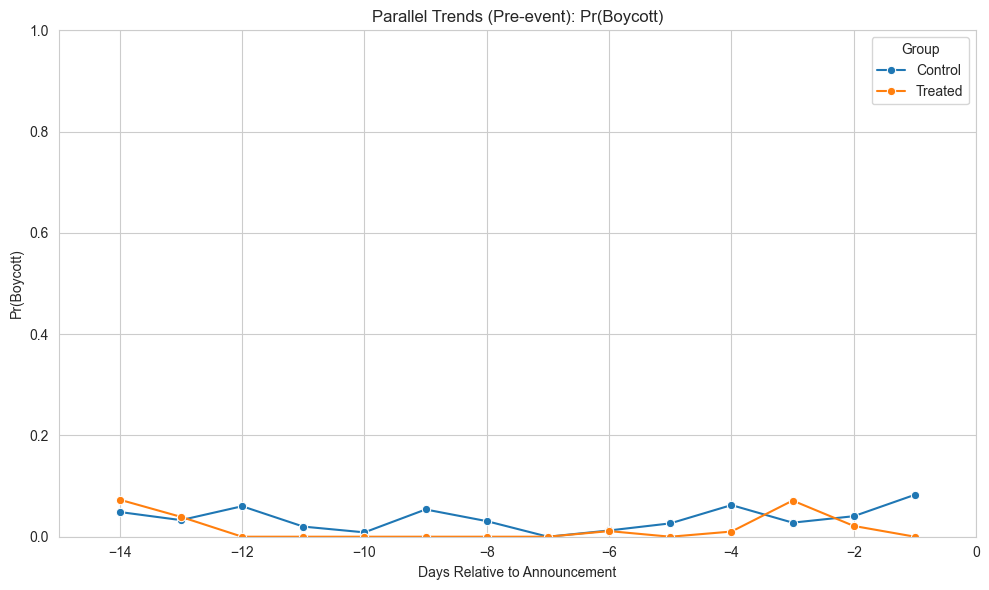

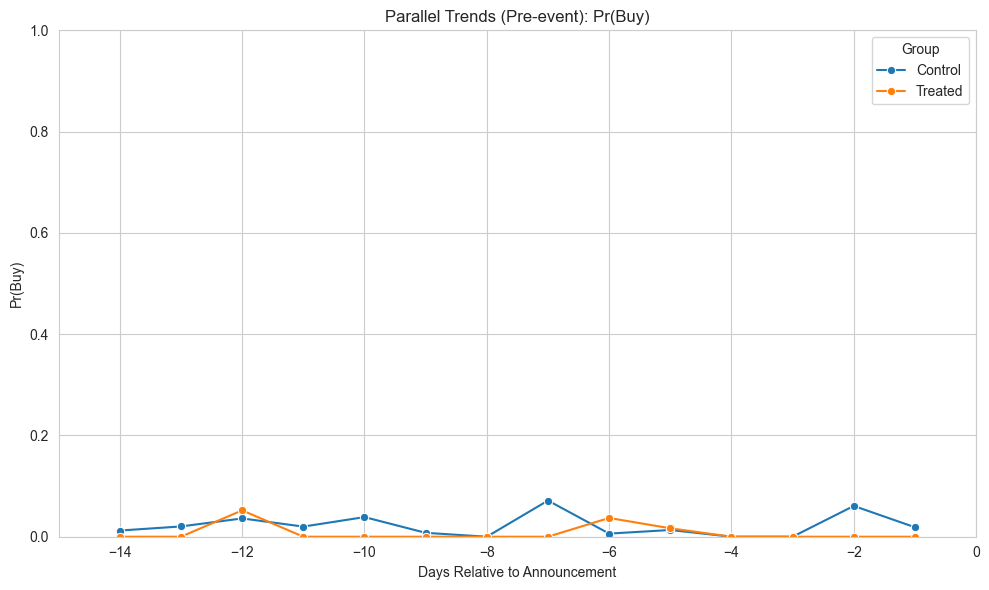

In [71]:
plot_parallel_trends(df_did, 'is_boycott', 'Pr(Boycott)', 'parallel_trends_boycott.png')
plot_parallel_trends(df_did, 'is_buy', 'Pr(Buy)', 'parallel_trends_buy.png')

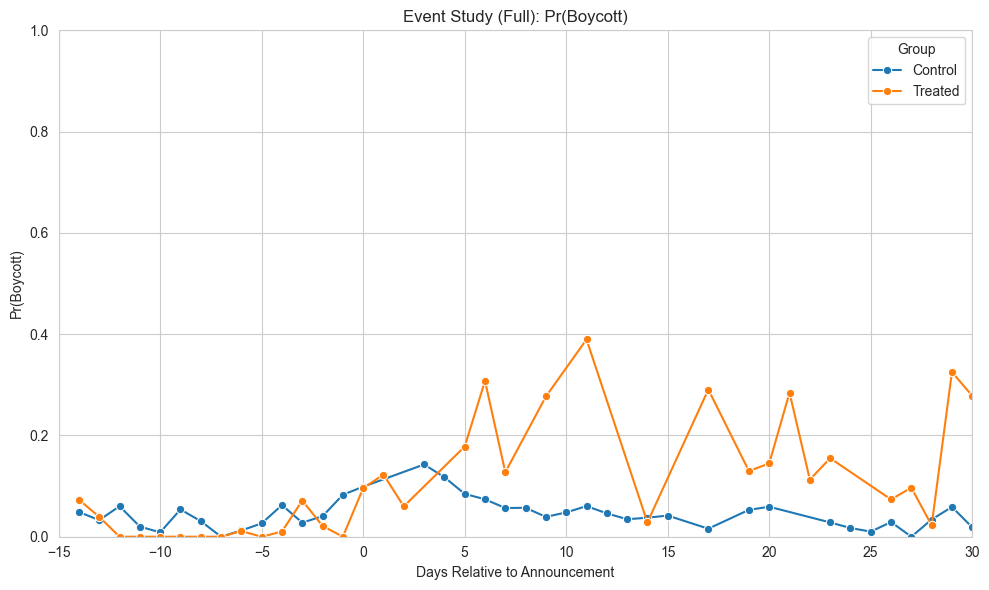

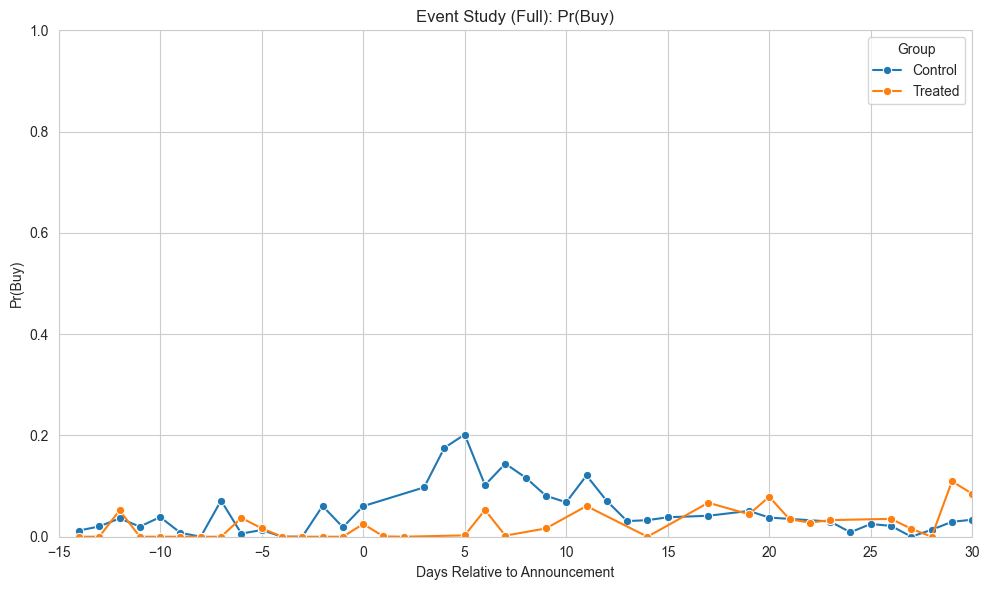

In [72]:
plot_event_study(df_did, 'is_boycott', 'Pr(Boycott)', 'parallel_trends_boycott.png')
plot_event_study(df_did, 'is_buy', 'Pr(Buy)', 'parallel_trends_buy.png')